In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import matplotlib.pyplot as plt

data = 'coin_Bitcoin.csv'
dataset = pd.read_csv(data)
chosen_col = 'Close'

In [3]:
print(len(dataset))
dataset.head()

2991


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


Splitting our data into what will be our training set VS the test set so we can visualize it.

In [4]:
split_row = len(dataset) - int(0.2 * len(dataset))
train_data = dataset.iloc[:split_row]
test_data = dataset.iloc[split_row:]

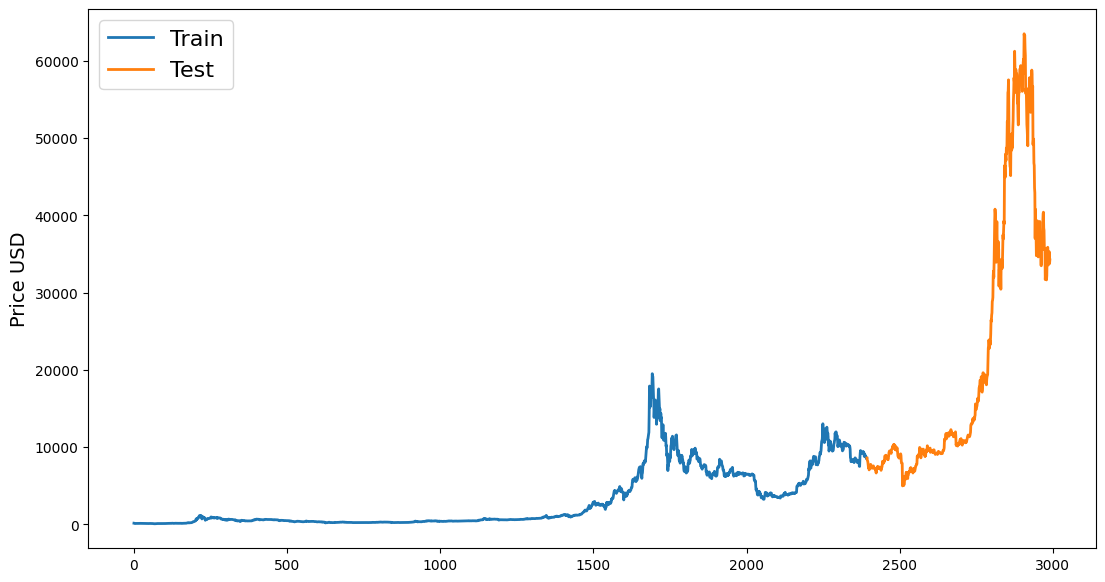

In [5]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(train_data[chosen_col], label='Train', linewidth=2)
ax.plot(test_data[chosen_col], label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [6]:
from sklearn.preprocessing import MinMaxScaler

datacol = dataset.iloc[:, 7:8].values
traincol = train_data.iloc[:, 7:8].values
testcol = test_data.iloc[:, 7:8].values

shaped_data = np.reshape(datacol, (-1,1))
train_shaped = np.reshape(traincol, (-1,1))
test_shaped = np.reshape(testcol, (-1,1))

sc = MinMaxScaler(feature_range=(0,1))
sc.fit(shaped_data)

train_scaled_data = sc.transform(train_shaped)
test_scaled_data = sc.transform(test_shaped)

Now we seperate our training data into our inputs and our outputs in time steps of time_steps. Where we will look at time_steps amount of data before we make our prediction of what the output for y will be.

In [7]:
X = []
y = []
time_steps = 50

for i in range(time_steps, len(train_data)):
    X.append(train_scaled_data[i-time_steps:i,0])
    y.append(train_scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

Splitting our training data into training and validation.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now we implement our actual model. We start with an LSTM input layer with 100 hidden units. We add a dropout of 0.2 before our Dense output layer with a linear activation and a shape of 1 (as we are outputting our expected price). We are using mean squared error to calculate our loss and adam as our optimizer.

In [9]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation

model = Sequential()
model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mse')

Fit our model now on our X and y training/validation data. We take advantage of keras' early stopping class so that once we are no longer recieving improvements the model will take its best weights and stop.

In [10]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1, callbacks=[callback], shuffle=True)

Epoch 1/100
59/59 [==============================] - 5s 61ms/step - loss: 0.0017 - val_loss: 1.1642e-04
Epoch 2/100
59/59 [==============================] - 3s 46ms/step - loss: 1.0444e-04 - val_loss: 1.0619e-04
Epoch 3/100
59/59 [==============================] - 3s 49ms/step - loss: 7.6278e-05 - val_loss: 8.4401e-05
Epoch 4/100
59/59 [==============================] - 3s 46ms/step - loss: 9.0639e-05 - val_loss: 7.4691e-05
Epoch 5/100
59/59 [==============================] - 3s 47ms/step - loss: 6.9107e-05 - val_loss: 8.0452e-05
Epoch 6/100
59/59 [==============================] - 3s 46ms/step - loss: 6.1242e-05 - val_loss: 7.1370e-05
Epoch 7/100
59/59 [==============================] - 3s 46ms/step - loss: 6.5279e-05 - val_loss: 8.0972e-05
Epoch 8/100
59/59 [==============================] - 3s 46ms/step - loss: 6.0663e-05 - val_loss: 6.6307e-05
Epoch 9/100
59/59 [==============================] - 3s 47ms/step - loss: 5.9905e-05 - val_loss: 6.4741e-05
Epoch 10/100
59/59 [============

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Now we are breaking our testing data up into time steps and splitting it again into our inputs and our expected outputs. 

We then predict on the inputs and then scale both the inputs and outputs back up, now were ready to see how we did!

In [12]:
from keras.metrics import mean_absolute_error

X_testing = []
y_testing = []

for i in range(time_steps, len(test_data)):
    X_testing.append(test_scaled_data[i-time_steps:i,0])
    y_testing.append(test_scaled_data[i, 0])

X_testing, y_testing = np.array(X_testing), np.array(y_testing)
X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))

predicted_price = model.predict(X_testing)
inv_price = sc.inverse_transform(predicted_price)
real_price = np.reshape(y_testing, (-1,1))
real_price = sc.inverse_transform(real_price)

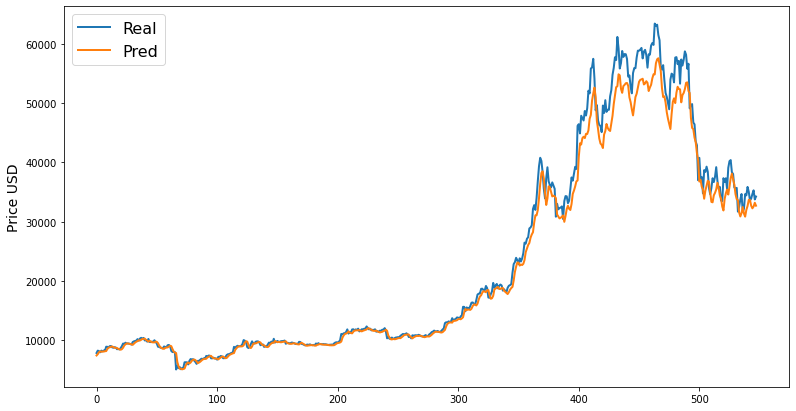

In [13]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(real_price, label='Real', linewidth=2)
ax.plot(inv_price, label='Pred', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)